## This will be the codebase for the dictionary learning portion

### Source Code for sklearn : https://github.com/scikit-learn/scikit-learn

In [1]:
from sklearn.feature_extraction import image as image_extractor
from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.decomposition import SparseCoder
from skimage import io
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
import csv
import numpy as np
import distutils
from distutils import util
from scipy import fftpack
import math
import time
import wavepy
import pandas as pd
import pdb

In [2]:
"""
First order discretization (linear voting in time)
    events in t,x,y,pol  numpy array
    Assume x and y are integer coordinates
    img_size: for example (180,240) for the DAVIS240C
    num_bins_t: 3-9, for example, 5
"""
def events2voxelgrid_linear(x, y, timestamp, pol, img_size, num_bins_t, t_min, dt_cell, use_polarity=True):
    assert len(x) == len(y) == len(pol) == len(timestamp)
    num_events = len(x)
    # creates a (180,240,num_bins_t) matrix to store the num_bins_t event frames
    # each frame will have both positive and negative events
    voxelgrid = np.zeros(img_size+(num_bins_t,), np.float64)
    for i in range(num_events-1):
        tn = (timestamp[i] - t_min) / dt_cell
        ti = int(tn)
        dt = tn - ti
        # Voting on two adjacent cells
        polarity = (2.*pol[i] - 1.) if use_polarity else 1.
        if ti < num_bins_t:
            voxelgrid[y[i], x[i], ti] += (1. - dt)*polarity
        if ti < num_bins_t-1:
            voxelgrid[y[i], x[i], ti+1] += dt*polarity
    print(np.sum(np.abs(voxelgrid)))  # This should equal the number of events
    return voxelgrid.astype('float32')

In [3]:
"""
Plot voxel grid as event frames
"""
def plotVoxelGridZSlices(voxelgrid):
    vmin = voxelgrid.min()
    vmax = voxelgrid.max()
    if np.sign(vmin) != 0 and (np.sign(vmin) != np.sign(vmax)):
        # if voxel grid uses polarity
        r_val = np.array([vmin,vmax])
        max_abs_val = np.max( np.abs(r_val) )
        vmin = -max_abs_val
        vmax = max_abs_val
        cmap_val = 'gray'
    else:
        # if voxel grid does not use polarity
        assert vmin >= 0
        cmap_val = 'gray_r'
    
    fig, axs = plt.subplots(int(np.ceil(voxelgrid.shape[2]/2.)), 2, figsize=(15, 15))
    for i in range(voxelgrid.shape[2]):
        plt.sca(axs[int(i/2),i%2])
        plt.imshow(voxelgrid[:,:,i], cmap=cmap_val, vmin=vmin, vmax=vmax)
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        
    if voxelgrid.shape[2] % 2 != 0:
        axs.flat[-1].set_visible(False)
    plt.show()

In [4]:
"""
Plot voxel grid as event frames
"""
def plotVoxelGridZSlicesAsOneColumn(voxelgrid):
    vmin = voxelgrid.min()
    vmax = voxelgrid.max()
    if np.sign(vmin) != 0 and (np.sign(vmin) != np.sign(vmax)):
        # if voxel grid uses polarity
        r_val = np.array([vmin,vmax])
        max_abs_val = np.max( np.abs(r_val) )
        vmin = -max_abs_val
        vmax = max_abs_val
        cmap_val = 'gray'
    else:
        # if voxel grid does not use polarity
        assert vmin >= 0
        cmap_val = 'gray_r'
    
    fig, axs = plt.subplots(voxelgrid.shape[2],1, figsize=(5, 25))
    for i in range(voxelgrid.shape[2]):
        plt.sca(axs[i])
        plt.imshow(voxelgrid[:,:,i], cmap=cmap_val, vmin=vmin, vmax=vmax)
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
    plt.show()

### Parameters of the method

In [5]:
patch_size = (5, 5)
max_patches = 80000  # Due to memory issues

# Event parameters: the number of events to be taken into consideration
num_time_slices = 7

# Method to compute voxel grids of events (time slices): nearest neighbor or linear voting
method_voting = 'Linear'

# Split by polarity (double grid size) or not?
split_by_polarity = True

# Atom size (determined by above parameters)
atom_size = patch_size[0]*patch_size[1] * (2 + num_time_slices * (2 if split_by_polarity else 1))
print('Num dims of an atom = ' + str(atom_size))

# Dictionary
num_elem_grads = 2*patch_size[0]*patch_size[1]
n_components = 4*(atom_size - num_elem_grads)
print('Num atoms in dictionary = ' + str(n_components))

# Scale factor to balance the energy of the derivatives and the events
C_scale = 100.

# Should use log scale instead of linear scale...

Num dims of an atom = 400
Num atoms in dictionary = 1400


### Read the image

In [6]:
image = io.imread("frame_00000561.png",as_gray=True).astype('float32')

Load as grayscale image (because we know that the image has no color), and also convert to floating point, to operate on real numbers, not on integers.

In [7]:
image.shape

(180, 240)

In [8]:
image.dtype

dtype('float32')

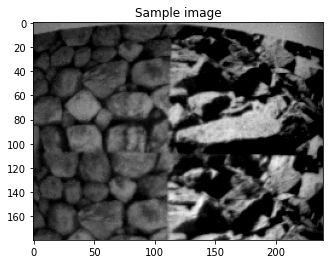

In [9]:
plt.imshow(image, cmap='gray')
plt.title('Sample image')
plt.show()

### Calculate the X and Y derivative using sobel operator. This is very good with edge detection

In [10]:
image_x = ndimage.sobel(image, axis=0).astype('float32') / C_scale
image_y = ndimage.sobel(image, axis=1).astype('float32') / C_scale

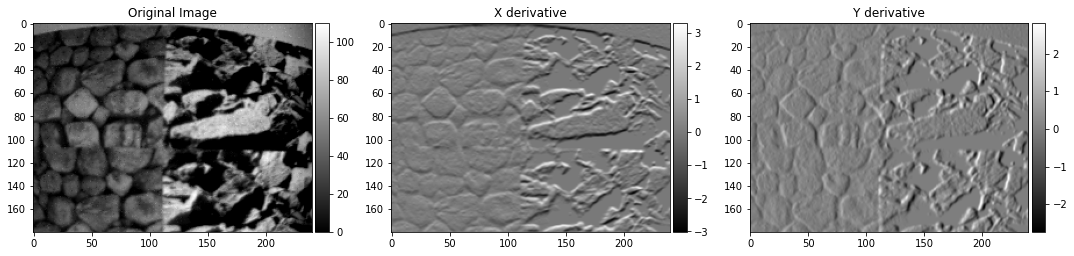

In [11]:
fig, (ax1,ax2, ax3) = plt.subplots(1, 3, figsize = (15, 5), sharex = True)

p1 = ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image')
# create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p1, cax=cax)

p2 = ax2.imshow(image_x, cmap='gray')
ax2.set_title('X derivative')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p2, cax=cax)

p3 = ax3.imshow(image_y, cmap='gray')
ax3.set_title('Y derivative')
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(p3, cax=cax)
fig.tight_layout(pad=1.0)
plt.show()

## Create the event histogram

Read events

In [12]:
# read the file and store it in different arrays 
timestamp = []
x = []
y = []
pol = []

with open('event_data12102020.csv') as csvfile:
    event_file = csv.reader(csvfile, delimiter=',')
    next(event_file)
    for row in event_file:
        if len(row) == 0:
            continue; # while writing, an additional alternative empty row is written in the excel. so skippping
        x.append(int(float(row[0])))
        y.append(int(float(row[1])))
        timestamp.append(float(row[2]))
        #pol.append(distutils.util.strtobool(row[3]))
        pol.append(int(float(row[3])))
        
assert len(x) == len(y) == len(pol) == len(timestamp)

In [13]:
total_num_events = len(x)

In [14]:
total_num_events

132886

In [15]:
# convert to arrays
x = np.array(x)
y = np.array(y)
timestamp = np.array(timestamp)
pol = np.array(pol)

In [16]:
# Divide the events into chunks of equal time span $\Delta t$, rather than equal number of events    
t_max = np.amax(timestamp)
t_min = np.amin(timestamp)
t_range = t_max - t_min
dt_cell = t_range / num_time_slices
t_edges = np.linspace(t_min,t_max,num_time_slices+1) # boundaries of the cells; not needed
print(t_min,t_max,t_range,dt_cell)

# Specify bin edges in each dimension
bin_edges = (np.linspace(0,image.shape[0],image.shape[0]+1), 
             np.linspace(0,image.shape[1],image.shape[1]+1), t_edges)

24.695670001 24.74567 0.04999999900000063 0.00714285700000009


In [17]:
if not split_by_polarity:
    # one voxel grid for all events (both polarities)
    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt = np.transpose(np.array([y, x, timestamp]))
        voxelgrid, _ = np.histogramdd(yxt, bins=bin_edges).astype('float32')
        del yxt
    else:
        print('Interpolated histogram')
        voxelgrid = events2voxelgrid_linear(x,y,timestamp,pol, 
                                            image.shape,num_time_slices,t_min,dt_cell,use_polarity=True)
    print(voxelgrid.shape)
    plotVoxelGridZSlices(voxelgrid)
    #plotVoxelGridZSlicesAsOneColumn(voxelgrid)

Interpolated histogram
69397.83991685811
(180, 240, 7)


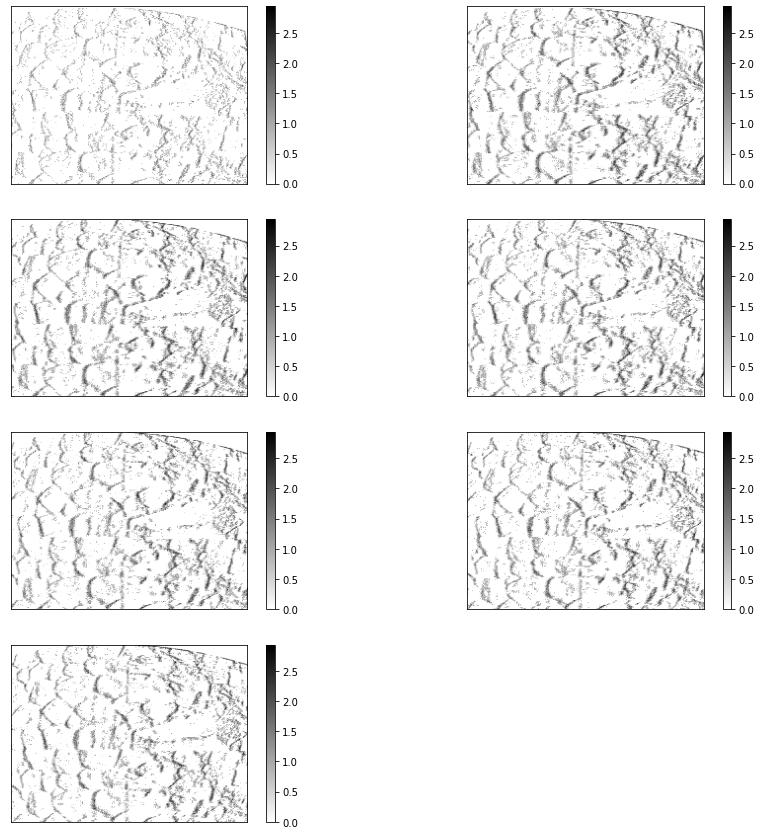

In [18]:
if split_by_polarity:
    # Positive events only
    idx_pos = pol==0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_pos = np.transpose(np.array([y[idx_pos], x[idx_pos], timestamp[idx_pos]]))
        voxelgrid_pos, _ = np.histogramdd(yxt_pos, bins=bin_edges).astype('float32')
        del yxt_pos
    else:
        print('Interpolated histogram')
        voxelgrid_pos = events2voxelgrid_linear(x[idx_pos],y[idx_pos],timestamp[idx_pos],pol[idx_pos], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_pos.shape)
    plotVoxelGridZSlices(voxelgrid_pos)
    #plotVoxelGridZSlicesAsOneColumn(voxelgrid_pos)

Interpolated histogram
54637.71597065535
(180, 240, 7)


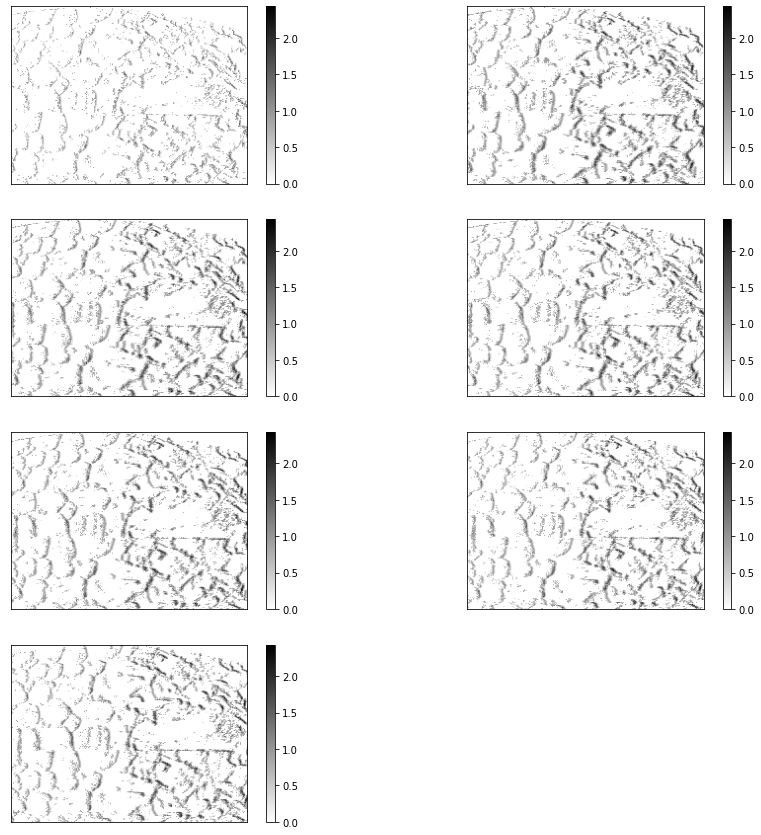

In [19]:
if split_by_polarity:
    # Negative events only
    idx_neg = pol!=0

    if (method_voting == 'nearest'):
        print('Regular histogram')
        yxt_neg = np.transpose(np.array([y[idx_neg], x[idx_neg], timestamp[idx_neg]]))
        voxelgrid_neg, _ = np.histogramdd(yxt_neg, bins=bin_edges).astype('float32')
        del yxt_neg
    else:
        print('Interpolated histogram')
        voxelgrid_neg = events2voxelgrid_linear(x[idx_neg],y[idx_neg],timestamp[idx_neg],pol[idx_neg], 
                                                image.shape,num_time_slices,t_min,dt_cell,use_polarity=False)
    print(voxelgrid_neg.shape)
    plotVoxelGridZSlices(voxelgrid_neg)
    #plotVoxelGridZSlicesAsOneColumn(voxelgrid_neg)

### Combine spatial gradient and temporal derivative (events) to create training patches

Stack the spatial gradient and the temporal derivative (events) on a single WxHxZ array to select the patches together on all Z slices with one single call to `extract_patches_2d`. As we have 5 events and 2 gradients. Z will be 7. W and H will be the image dimension. 

In [20]:
image_gradient = np.concatenate((np.expand_dims(image_x, axis=2), np.expand_dims(image_y, axis=2)), axis=2)
print(image_gradient.shape)
if split_by_polarity:
    voxelgrid = np.concatenate((voxelgrid_pos,voxelgrid_neg), axis=2)
data = np.concatenate((image_gradient, voxelgrid), axis=2)
del image_gradient

(180, 240, 2)


In [21]:
data.shape

(180, 240, 16)

In [22]:
data.dtype

dtype('float32')

Extract patches

- [X] Check if patches being extracted is correct or not ?

In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.extract_patches_2d.html
# source code : https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/image.py
data_patches = image_extractor.extract_patches_2d(data, patch_size, max_patches)
data_patches.shape

C:\Users\sudes\softwares\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass max_patches=80000 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


(41536, 5, 5, 16)

Till here we have extracted all the patches from the 7 layers 

In [24]:
# Plot the information of this patch:
idx_patch = 31

nrm_large = 0
for i in range(int(max_patches/5)):
    # why do this step ?
    ww = data_patches[i].reshape(patch_size[0],patch_size[1],-1)
    nrm = np.linalg.norm(ww)
    if nrm > nrm_large:
        nrm_large = nrm
        idx_patch = i

idx_patch

14526

(5, 5, 16)


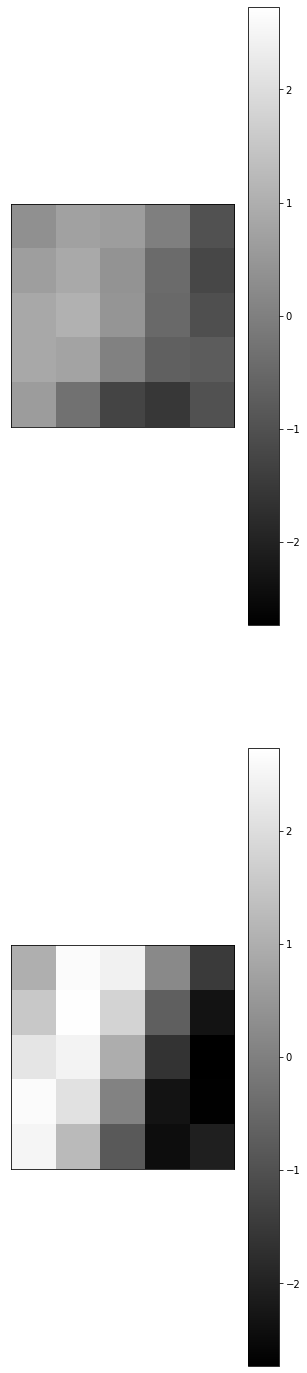

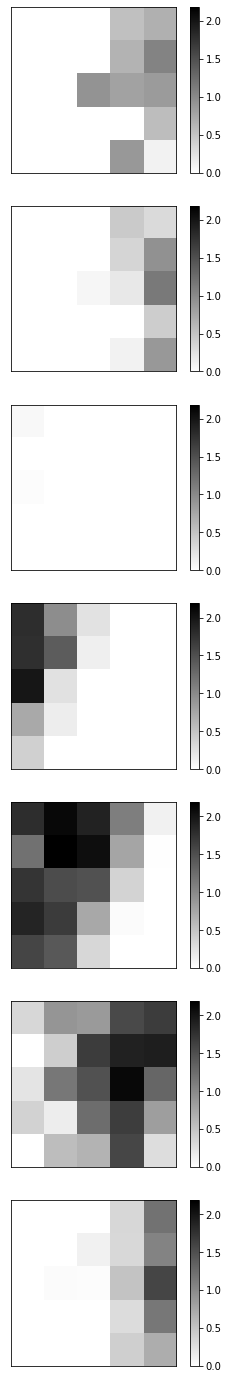

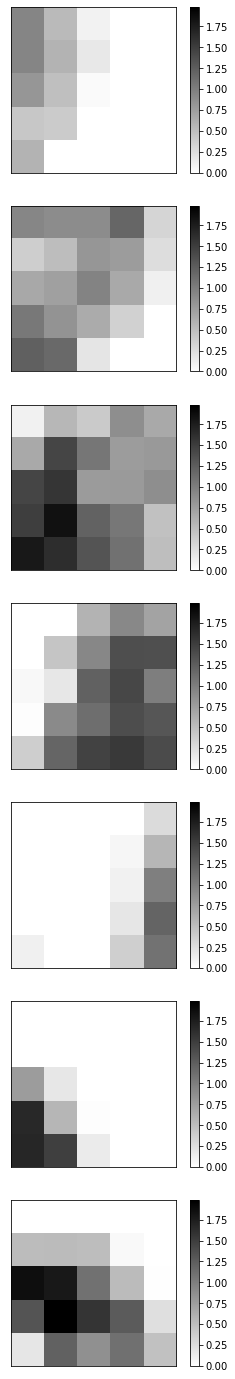

In [25]:
ww = data_patches[idx_patch].reshape(patch_size[0],patch_size[1],-1)
print( ww.shape )
#plotVoxelGridZSlicesAsOneColumn(ww) # Masking effect by unbalanced orders of magnitude
plotVoxelGridZSlicesAsOneColumn(ww[:,:,0:2])
if split_by_polarity:
    plotVoxelGridZSlicesAsOneColumn(ww[:,:,2:2+num_time_slices]) # positive events
    plotVoxelGridZSlicesAsOneColumn(ww[:,:,2+num_time_slices:]) # negative events
else:
    plotVoxelGridZSlicesAsOneColumn(ww[:,:,2:]) # events of both polarities

Prepare (reshape) data for call to dictionary learning function

In [26]:
data_patches = data_patches.reshape(data_patches.shape[0], -1)
data_patches.shape

(41536, 400)

In [27]:
data_patches.dtype

dtype('float32')

Prune patches with low energy

In [28]:
nrm_patches = np.zeros((data_patches.shape[0],1))
for i in range(data_patches.shape[0]):
    nrm_patches[i] = np.linalg.norm(data_patches[i,:num_elem_grads])

In [29]:
nrm_patches.mean()

2.8766042113971237

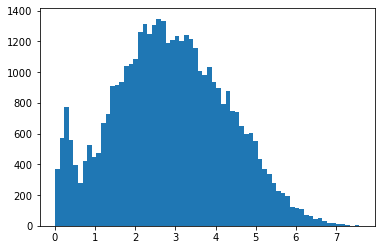

In [30]:
_ = plt.hist(nrm_patches, bins='auto')
plt.show()

In [31]:
thr = nrm_patches.mean()+2*nrm_patches.std()
print(thr)

5.698853245256357


In [32]:
#thr = nrm_patches.mean()+2*nrm_patches.std()
thr = nrm_patches.mean()
print(thr)
data_patches = np.delete(data_patches, np.where( nrm_patches < thr )[0], 0)
data_patches.shape

2.8766042113971237


(20323, 400)

In [33]:
print('Learning the dictionary...')
dico = MiniBatchDictionaryLearning(n_components=n_components, alpha=1, n_iter=500)

# Normalization
data_patches -= np.mean(data_patches, axis=0)
data_patches /= np.std(data_patches, axis=0)

# Actual learning
start_time = time.time()
V = dico.fit(data_patches).components_
elapsed_time = time.time() - start_time
print('Elapsed time = %.2fs' % elapsed_time)
print(V.shape)

Learning the dictionary...
Elapsed time = 1105.92s
(1400, 400)


In [34]:
V.dtype

dtype('float64')

Visualize the atoms:

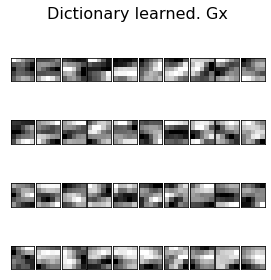

In [35]:
num_atoms_plot = 40
if (num_atoms_plot > n_components):
    num_atoms_plot = n_components

plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,0], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Gx\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

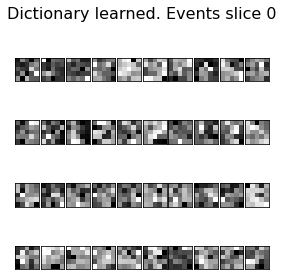

In [36]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:num_atoms_plot]):
    plt.subplot(int(num_atoms_plot/10), 10, i + 1)
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    plt.imshow(atom[:,:,2], cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Dictionary learned. Events slice 0\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

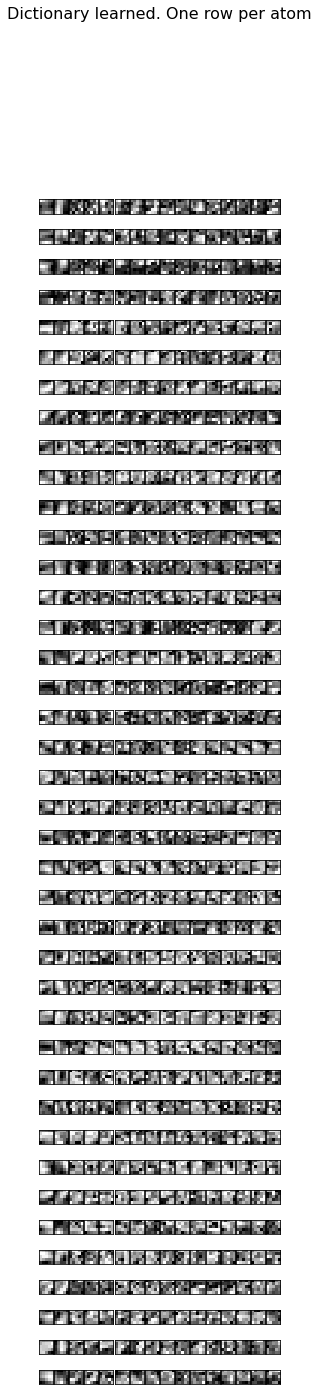

In [37]:
plt.figure(figsize=(4,num_atoms_plot*0.5))
for i, comp in enumerate(V[:num_atoms_plot]):
    atom = comp.reshape(patch_size[0],patch_size[0],-1)
    for j in range(data.shape[2]):
        plt.subplot(num_atoms_plot, data.shape[2], data.shape[2]*i + j + 1)
        plt.imshow(atom[:,:,j], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())
plt.suptitle('Dictionary learned. One row per atom\n', fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

Dg: Part of the dictionary corresponding to the spatial gradients (the upper part of V)

In [38]:
V_gradients = V[:,:num_elem_grads]
V_gradients.shape

(1400, 50)

De: Part of the dictionary corresponding to the events (the bottom part of V)

In [39]:
V_events = V[:,num_elem_grads:]
V_events.shape

(1400, 350)

In [40]:
dico

MiniBatchDictionaryLearning(n_components=1400, n_iter=500)

In [41]:
data_test = image_extractor.extract_patches_2d(voxelgrid, patch_size)
data_test.shape

(41536, 5, 5, 14)

In [42]:
data_test = data_test.reshape(data_test.shape[0], -1)
intercept = np.mean(data_test, axis=0)
print(intercept.shape)
data_test -= intercept
data_test.shape

(350,)


(41536, 350)

In [43]:
n_coefs = 3
coder = SparseCoder(dictionary=V_events, transform_algorithm='omp', transform_n_nonzero_coefs=n_coefs)
#coder = SparseCoder(dictionary=V_events, transform_algorithm='omp')

In [44]:
np.transpose(data_test).shape

(350, 41536)

In [45]:
start_time = time.time()
code = coder.transform(data_test)
elapsed_time = time.time() - start_time
print('Elapsed time = %.2fs' % elapsed_time)

Elapsed time = 443.86s


In [46]:
code.shape

(41536, 1400)

In [47]:
patches_g = np.dot(code, V_gradients)
patches_g.shape

(41536, 50)

In [48]:
patches_g = patches_g.reshape(patches_g.shape[0],patch_size[0],patch_size[1],2)
patches_g.shape

(41536, 5, 5, 2)

In [49]:
reconstruction = image_extractor.reconstruct_from_patches_2d(patches_g, (image.shape[0],image.shape[1],2))
reconstruction.shape

(180, 240, 2)

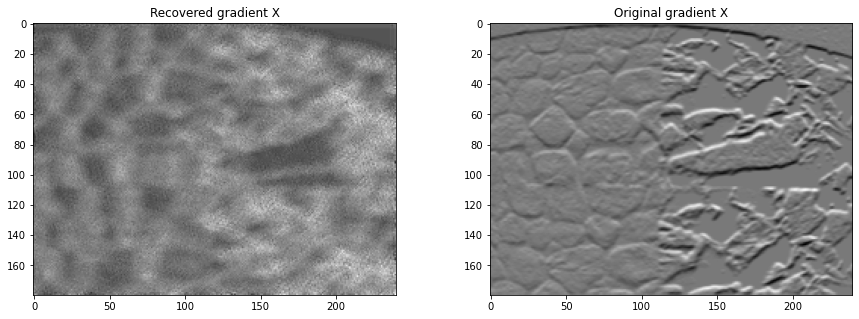

In [50]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex = True)

plt.sca(ax1)
plt.imshow(reconstruction[:,:,0], cmap='gray')
plt.title('Recovered gradient X')

plt.sca(ax2)
plt.imshow(image_x, cmap='gray')
plt.title('Original gradient X')
plt.show()

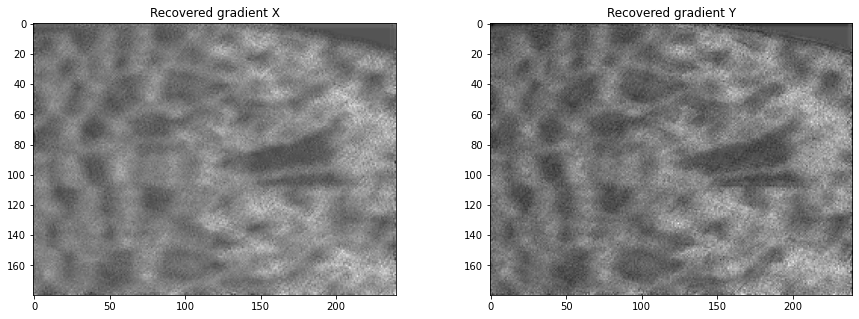

In [51]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize = (15, 5), sharex = True)

plt.sca(ax1)
plt.imshow(reconstruction[:,:,0], cmap='gray')
plt.title('Recovered gradient X')

plt.sca(ax2)
plt.imshow(reconstruction[:,:,1], cmap='gray')
plt.title('Recovered gradient Y')
plt.show()

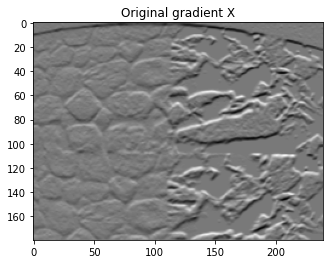

In [51]:
plt.imshow(image_x, cmap='gray')
plt.title('Original gradient X')
plt.show()

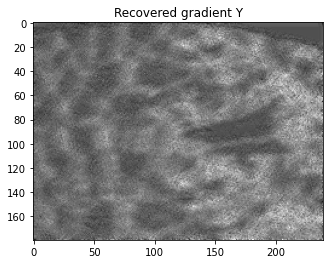

In [52]:
plt.imshow(reconstruction[:,:,1], cmap='gray')
plt.title('Recovered gradient Y')
plt.show()

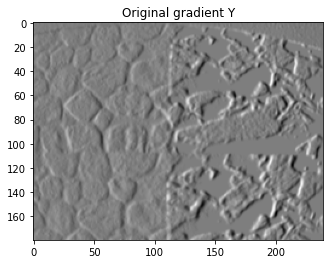

In [53]:
plt.imshow(image_y, cmap='gray')
plt.title('Original gradient Y')
plt.show()

TO DO: 
- [x] compute histograms (Ep,En) using linear voting instead of regular voting
- [x] test with a single voxel grid (with polarity), instead of two (Ep,En)
- [x] better plot the dictionaty. One atom per row
- [x] reconstruction with the learned dictionary
- are gx,gy dominating the largest components? Or are all dimensions independent? Do we need to rescale?
- debug reconstruction. Results do not look good.

In [73]:
df_x = pd.DataFrame(data=image_x.astype(np.float))
df_x.to_csv('image_x.dat', sep=' ', header=False)

In [74]:
df_y = pd.DataFrame(data=image_y.astype(np.float))
df_y.to_csv('image_y.dat', sep=' ', header=False)

In [77]:
df_x_rec = pd.DataFrame(data=reconstruction[:,:,0].astype(np.float))
df_x_rec.to_csv('image_x_rec.dat', sep=' ', header=False)

In [78]:
df_y_rec = pd.DataFrame(data=reconstruction[:,:,1].astype(np.float))
df_y_rec.to_csv('image_y_rec.dat', sep=' ', header=False)